In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '15/10/2020'
id_noticia = '244806'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [5]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0].str.replace('*', '')

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,8.991,787,107,126,6.866,15/10/2020
1,Cádiz,8.835,1.044,120,243,4.116,15/10/2020
2,Córdoba,9.231,1.110,133,203,3.739,15/10/2020
3,Granada,12.269,1.722,164,367,4.488,15/10/2020
4,Huelva,2.096,301,36,62,792,15/10/2020
5,Jaén,7.261,1.148,121,231,3.380,15/10/2020
6,Málaga,18.376,2.505,241,436,10.073,15/10/2020
7,Sevilla,18.397,2.426,217,429,6.306,15/10/2020
8,Total,85.456,11.043,1.139,2.097,39.760,15/10/2020


In [6]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [7]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [8]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [9]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [10]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [11]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [12]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2020-10-15,147.0,0.0,6.0,84.0,0.0
Cádiz,2020-10-15,73.0,1.0,13.0,158.0,0.0
Córdoba,2020-10-15,118.0,0.0,14.0,156.0,0.0
Granada,2020-10-15,121.0,0.0,8.0,360.0,1.0
Huelva,2020-10-15,12.0,0.0,1.0,46.0,0.0
Jaén,2020-10-15,6.0,1.0,9.0,321.0,0.0
Málaga,2020-10-15,236.0,2.0,17.0,193.0,3.0
Sevilla,2020-10-15,86.0,7.0,34.0,653.0,0.0
Total,2020-10-15,799.0,11.0,102.0,1971.0,4.0


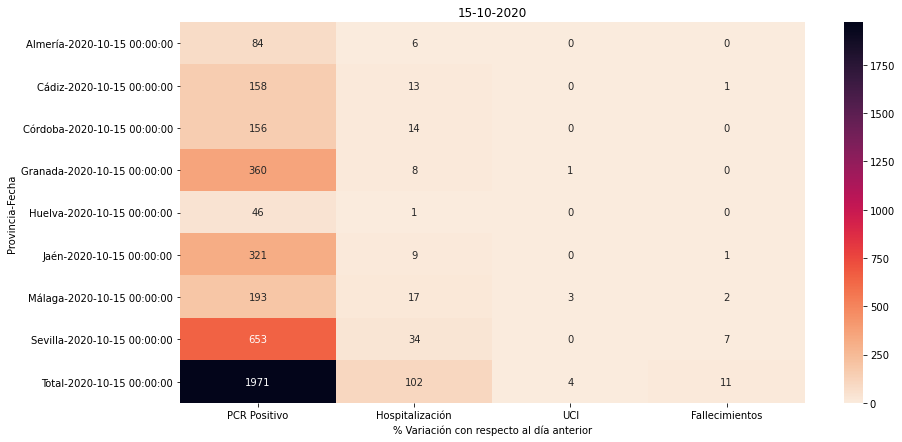

In [13]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [14]:
filtro = 'Total'
provincia = 'Andalucía'
dias = 120
data = df.loc[filtro].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia


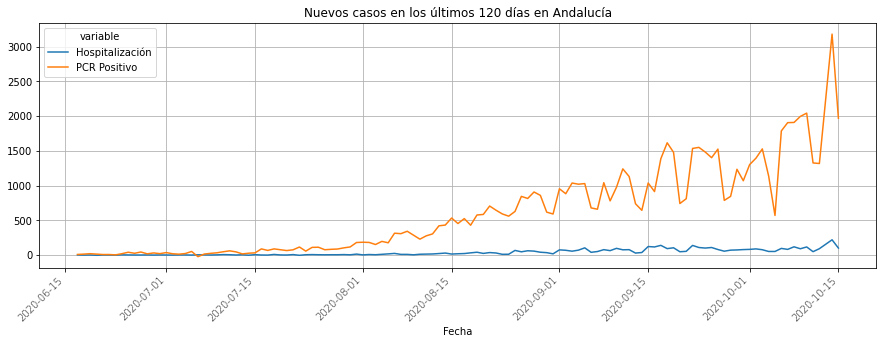

In [15]:
# print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
data[['Hospitalización', 'PCR Positivo']].plot(
    kind='line', grid=True, figsize=(15,5), title=titulo)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Total,2020-10-15,102.0,0 days
Sevilla,2020-10-15,34.0,0 days
Málaga,2020-10-15,17.0,0 days
Jaén,2020-10-15,9.0,0 days
Huelva,2020-10-15,1.0,0 days
Granada,2020-10-15,8.0,0 days
Córdoba,2020-10-15,14.0,0 days
Cádiz,2020-10-15,13.0,0 days
Almería,2020-10-15,6.0,0 days


In [17]:
# Fecha de último ingreso en hospital
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,UCI,dias
Provincia,,,
Huelva,2020-10-02,1.0,13 days
Almería,2020-10-10,1.0,5 days
Sevilla,2020-10-14,3.0,1 days
Jaén,2020-10-14,1.0,1 days
Córdoba,2020-10-14,3.0,1 days
Cádiz,2020-10-14,3.0,1 days
Total,2020-10-15,4.0,0 days
Málaga,2020-10-15,3.0,0 days
Granada,2020-10-15,1.0,0 days
